<a href="https://colab.research.google.com/github/Saugatn3/Anomaly-Detection-in-Time-Series-using-GRU-Autoencoders/blob/main/gru-auto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import GRU,LSTM, Input, Dropout
from keras.layers import RepeatVector
from keras.layers import Dense

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks'

In [ ]:
os.listdir(dataset_path)

['dataset_mpu_acc_xyz.csv',
 'data.csv',
 'Untitled1.ipynb',
 'crashdetection.h5',
 'dataset.csv',
 'crashdetection2.h5',
 'crashdetection3.h5',
 'dataset2.csv',
 'check.csv',
 'gkpmy.csv',
 'Untitled0.ipynb']

In [ ]:
#df = pd.read_csv(os.path.join(dataset_path, 'dataset_mpu_acc_xyz.csv'))
df = pd.read_csv(os.path.join(dataset_path, 'data.csv'))
df

,acc_x,acc_y,acc_z
0,0.37,0.17,9.79
1,0.39,0.18,9.77
2,0.41,0.18,9.73
3,0.37,0.16,9.75
4,0.39,0.16,9.87
...,...,...,...
44717,0.48,-0.37,10.68
44718,0.33,-0.61,10.69
44719,1.70,-0.43,10.06
44720,0.06,-0.17,9.75


In [ ]:
df.describe()

,acc_x,acc_y,acc_z
count,44722.000000,44722.000000,44722.000000
mean,0.041763,0.054959,9.746948
std,0.907097,0.838667,1.333418
min,-6.430000,-9.650000,-12.960000
25%,-0.420000,-0.330000,9.300000
50%,0.230000,0.150000,9.780000
75%,0.420000,0.400000,10.200000
max,8.880000,8.200000,19.610000


In [ ]:
split_index = int(0.85 * len(df))

# Splitting the data into train and test sets
train = df.iloc[:split_index]
test = df.iloc[split_index:]

scaler = StandardScaler()

scaler = scaler.fit(train[['acc_x', 'acc_y', 'acc_z']])

train[['acc_x', 'acc_y', 'acc_z']] = scaler.transform(train[['acc_x', 'acc_y', 'acc_z']])
test[['acc_x', 'acc_y', 'acc_z']] = scaler.transform(test[['acc_x', 'acc_y', 'acc_z']])
std = np.sqrt(scaler.var_)
std,scaler.mean_

<ipython-input-10-357f6bcdce04>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['acc_x', 'acc_y', 'acc_z']] = scaler.transform(train[['acc_x', 'acc_y', 'acc_z']])
<ipython-input-10-357f6bcdce04>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['acc_x', 'acc_y', 'acc_z']] = scaler.transform(test[['acc_x', 'acc_y', 'acc_z']])


(array([0.86023712, 0.86885321, 1.34532993]),
 array([0.01252124, 0.08577487, 9.73643464]))

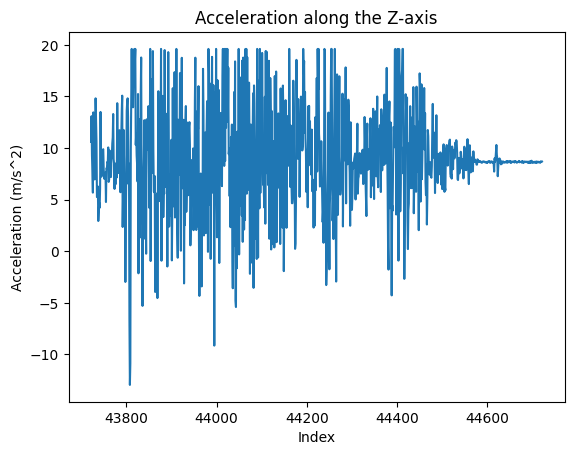

In [ ]:
plt.plot(df['acc_z'].tail(1000))
plt.xlabel('Index')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Acceleration along the Z-axis')
plt.show()

In [ ]:
seq_size=5
def to_sequences(x, seq_size=1):
    x_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
    return np.array(x_values)

trainX= to_sequences(train, seq_size)
testX = to_sequences(test[['acc_x', 'acc_y', 'acc_z']],seq_size)
trainX

array([[[ 0.4155584 ,  0.09693828,  0.03981578],
        [ 0.4388078 ,  0.1084477 ,  0.02494954],
        [ 0.4620572 ,  0.1084477 , -0.00478295],
        [ 0.4155584 ,  0.08542885,  0.0100833 ],
        [ 0.4388078 ,  0.08542885,  0.09928075]],

       [[ 0.4388078 ,  0.1084477 ,  0.02494954],
        [ 0.4620572 ,  0.1084477 , -0.00478295],
        [ 0.4155584 ,  0.08542885,  0.0100833 ],
        [ 0.4388078 ,  0.08542885,  0.09928075],
        [ 0.38068429,  0.11995713,  0.0472489 ]],

       [[ 0.4620572 ,  0.1084477 , -0.00478295],
        [ 0.4155584 ,  0.08542885,  0.0100833 ],
        [ 0.4388078 ,  0.08542885,  0.09928075],
        [ 0.38068429,  0.11995713,  0.0472489 ],
        [ 0.36905959,  0.07391943,  0.0100833 ]],

       ...,

       [[ 0.38068429, -0.38645753,  0.41890494],
        [ 0.90379587, -1.67551302,  0.06954826],
        [ 0.4155584 , -1.376268  ,  0.42633806],
        [ 0.71780065, -1.53739994, -0.21291033],
        [ 0.90379587, -0.27136329, -0.49536892]],


In [ ]:
model = Sequential()
model.add(GRU(64, input_shape=(trainX.shape[1], trainX.shape[2])))

model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                13248     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 5, 64)             0         
 tor)                                                            
                                                                 
 gru_3 (GRU)                 (None, 5, 64)             24960     
                                                                 
 dropout_3 (Dropout)         (None, 5, 64)             0         
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 3)              195       
 stributed)                                           

In [ ]:
history = model.fit(trainX, trainX, epochs=40, batch_size=32, validation_split=0.1,shuffle=False, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],verbose=1)

Epoch 1/40
1069/1069 [==============================] - 16s 11ms/step - loss: 0.4465 - val_loss: 0.2550
Epoch 2/40
1069/1069 [==============================] - 11s 10ms/step - loss: 0.3865 - val_loss: 0.2205
Epoch 3/40
1069/1069 [==============================] - 11s 10ms/step - loss: 0.3408 - val_loss: 0.1991
Epoch 4/40
1069/1069 [==============================] - 11s 10ms/step - loss: 0.3221 - val_loss: 0.1891
Epoch 5/40
1069/1069 [==============================] - 11s 10ms/step - loss: 0.3042 - val_loss: 0.1692
Epoch 6/40
1069/1069 [==============================] - 11s 10ms/step - loss: 0.2891 - val_loss: 0.1620
Epoch 7/40
1069/1069 [==============================] - 11s 10ms/step - loss: 0.2672 - val_loss: 0.1444
Epoch 8/40
1069/1069 [==============================] - 10s 9ms/step - loss: 0.2464 - val_loss: 0.1296
Epoch 9/40
1069/1069 [==============================] - 11s 10ms/step - loss: 0.2260 - val_loss: 0.1218
Epoch 10/40
1069/1069 [==============================] - 11s 11ms

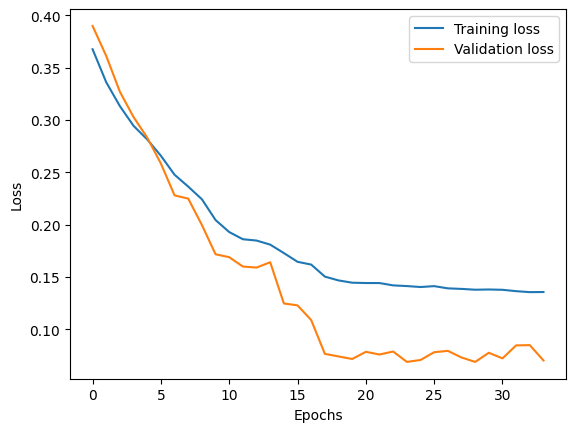

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

1188/1188 [==============================] - 5s 4ms/step


(array([[3.7674e+04, 2.3700e+02, 6.4000e+01, 2.2000e+01, 8.0000e+00,
         2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.7628e+04, 2.6300e+02, 8.5000e+01, 2.0000e+01, 9.0000e+00,
         2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.7407e+04, 2.6300e+02, 1.4100e+02, 7.8000e+01, 4.5000e+01,
         2.8000e+01, 1.4000e+01, 8.0000e+00, 9.0000e+00, 3.0000e+00,
         2.0000e+00, 2.0000e+00,

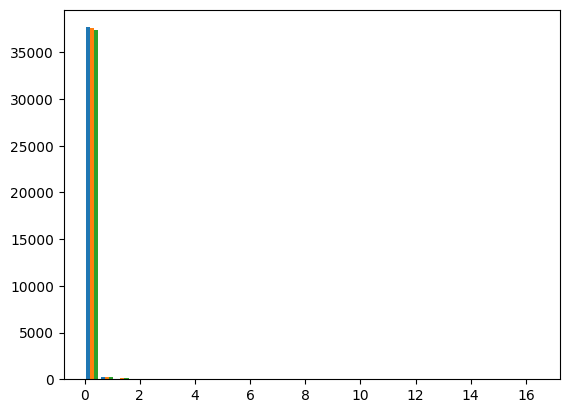

In [ ]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
trainMSE = np.mean((trainPredict - trainX)**2, axis=1)
plt.hist(trainMSE,bins=30)

210/210 [==============================] - 2s 8ms/step


(array([[3.166e+03, 1.677e+03, 7.700e+02, 4.630e+02, 2.420e+02, 1.520e+02,
         8.900e+01, 6.100e+01, 3.200e+01, 1.400e+01, 1.000e+01, 7.000e+00,
         5.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
         5.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
         1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
        [5.657e+03, 8.650e+02, 1.130e+02, 3.700e+01, 1.300e+01, 4.000e+00,
         5.000e+00, 4.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [5.804e+03, 6.980e+02, 1.120e+02, 3.800e+01, 1.300e+01, 1.200e+01,
         1.000e+01, 3.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
         2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
         0.000e+00, 0.0

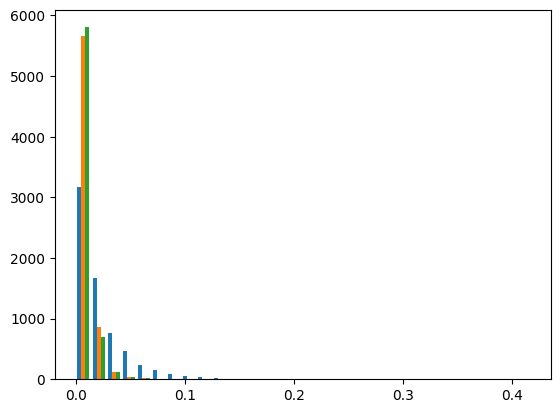

In [ ]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
testMSE = np.mean((testPredict - testX)**2, axis=1)
plt.hist(testMSE, bins=30)

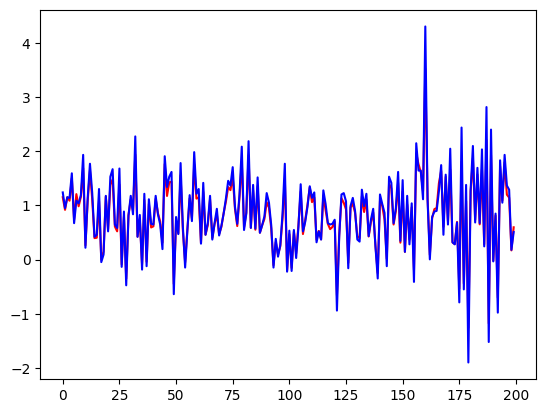

In [ ]:
plt.plot(testPredict[:200,0,0],color='r')
plt.plot(testX[:200,0,0],color='b')

In [ ]:
data = pd.read_csv(os.path.join(dataset_path, 'check.csv'))
data = pd.DataFrame(data,columns=['acc_x','acc_y','acc_z'])
data.head()

,acc_x,acc_y,acc_z
0,-0.16,-0.49,8.67
1,-0.20,-0.49,8.75
2,-0.19,-0.44,8.64
3,-0.18,-0.45,8.55
4,-0.21,-0.44,8.63


In [ ]:
data[['acc_x','acc_y','acc_z']] = scaler.transform(data[['acc_x','acc_y','acc_z']])
data[['acc_x','acc_y','acc_z']]

,acc_x,acc_y,acc_z
0,-0.200551,-0.662684,-0.792694
1,-0.247050,-0.662684,-0.733229
2,-0.235425,-0.605137,-0.814993
3,-0.223800,-0.616646,-0.881891
4,-0.258674,-0.605137,-0.822426
...,...,...,...
1716,-0.247050,-0.743250,-0.867025
1717,-0.316798,-0.777778,-0.762961
1718,-0.316798,-0.766269,-0.792694
1719,-0.293548,-0.743250,-0.800127


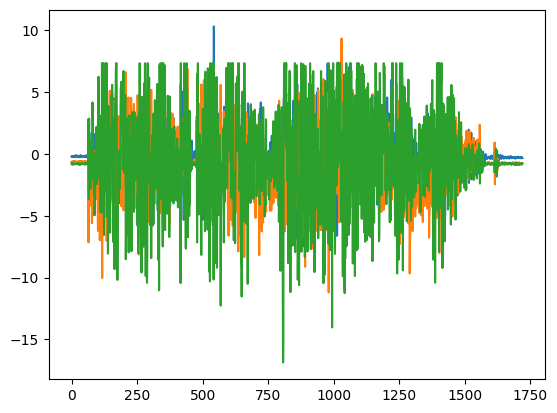

In [ ]:
plt.plot(data)
new= to_sequences(data[['acc_x','acc_y','acc_z']], seq_size)

54/54 [==============================] - 0s 7ms/step


(array([[366., 277., 263., 249., 218., 125.,  96.,  46.,  39.,  16.,  13.,
           5.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [349., 277., 290., 224., 188., 130., 109.,  72.,  39.,  25.,   7.,
           4.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [363., 193., 217., 174., 155., 126., 122., 106.,  69.,  62.,  39.,
          27.,  17.,  17.,  10.,   7.,   3.,   0.,   1.,   1.,   0.,   0.,
           1.,   1.,   0.,   2.,   1.,   1.,   0.,   1.]]),
 array([0.0065071 , 0.12600495, 0.2455028 , 0.36500064, 0.48449849,
        0.60399634, 0.72349419, 0.84299203, 0.96248988, 1.08198773,
        1.20148558, 1.32098343, 1.44048127, 1.55997912, 1.67947697,
        1.79897482, 1.91847267, 2.03797051, 2.15746836, 2.27696621,
        2.39646406, 2.5159619 , 2.63545975, 2.7549576 , 2.87445545,
        2.9939533 , 3.11345114, 3.

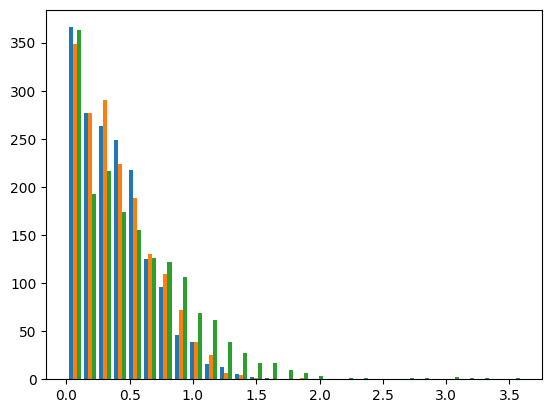

In [ ]:
newPredict = model.predict(new)
newMAE = np.mean(np.abs(newPredict - new), axis=1)
newMSE = np.mean((newPredict - new)**2, axis=1)
plt.hist(newMAE, bins=30)

In [ ]:
anomalies = newMAE > 0.35
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
model.save('gkpmy.h5')